## $d=2$ Elder convection example

$$\Omega = [0, L_x] \times [0, L_y]$$

$$c_0(x,y)=\mathcal{N}(x,y)$$

$$c(x,y=0)=0$$

$$c(x,y=L_y)=\begin{cases}
1 & x<\frac{L_x}{2} \\
0 & \text{otherwise}
\end{cases}$$

$$\frac{\partial c}{\partial x}\bigg\vert_{x=0,y}=\frac{\partial c}{\partial x}\bigg\vert_{x=L_x,y}=0$$

$$\psi\vert_{\partial\Omega}=0$$

$$\textbf{e}_g=-\textbf{e}_y \implies e_g^x=0~,~e_g^y=-1$$

$$
\begin{align*}
\phi &= 1 \\
\mathsf{D} &= \mathsf{I} \\ 
\mathsf{K} &= \mathsf{I}\\ 
\mu &= 1 \\
\rho(c) &= c
\end{align*}
$$

In [ ]:
from lucifex.fdm import FiniteDifference, AB2, CN
from lucifex.solver import BoundaryConditions, OptionsPETSc
from lucifex.sim import Simulation, integrate, configure_simulation
from lucifex.utils import CellType, SpatialPerturbation, cubic_noise
from lucifex.viz import plot_colormap
from lucifex.io import write

from py.porous_convection import create_simulation, create_rectangle_domain


@configure_simulation(
    store_step=1,
    write_step=None,
)
def elder_convection_2d(
    # domain
    Lx: float = 2.0,
    Ly: float = 1.0,
    Nx: int = 100,
    Ny: int = 100,
    cell: str = CellType.QUADRILATERAL,
    # physical
    Ra: float = 5e2,
    # initial perturbation
    c_eps: float = 1e-6,
    c_freq: tuple[int, int] = (8, 8),
    c_seed: tuple[int, int] = (1234, 5678),
    # time step
    dt_max: float = 0.5,
    cfl_h: str | float = "hmin",
    cfl_courant: float = 0.75,
    # time discretization
    D_adv: FiniteDifference | tuple[FiniteDifference, FiniteDifference] = (AB2, CN),
    D_diff: FiniteDifference = CN,
    # linear algebra
    psi_petsc: OptionsPETSc | None = None,
    c_petsc: OptionsPETSc | None = None,
    # secondary
    secondary: bool = False,
) -> Simulation:
    Omega, dOmega = create_rectangle_domain(Lx, Ly, Nx, Ny, cell)
    c_bcs = BoundaryConditions(
        ("dirichlet", dOmega['lower'], 0.0),
        ("dirichlet", dOmega['upper'], lambda x: 0.0 + 1.0 * (x[0] < Lx / 2)),
        ('neumann', dOmega['left', 'right'], 0.0)
    )
    c_ics = SpatialPerturbation(
        0.0,
        cubic_noise(['neumann', 'dirichlet'], [Lx, Ly], c_freq, c_seed),
        [Lx, Ly],
        c_eps,
        ) 
    density = lambda c: c
    return create_simulation(
        Omega=Omega, 
        dOmega=dOmega, 
        Ra=Ra, 
        c_ics=c_ics, 
        c_bcs=c_bcs, 
        density=density, 
        dt_max=dt_max, 
        cfl_h=cfl_h, 
        cfl_courant=cfl_courant,
        D_adv=D_adv, 
        D_diff=D_diff, 
        psi_petsc=psi_petsc, 
        c_petsc=c_petsc, 
        secondary=secondary,
    )

In [2]:
simulation = elder_convection_2d(
    Lx=2.0,
    Ly=1.0,
    Nx=64,
    Ny=64,
    cell='quadrilateral', 
    Ra=400.0, 
    c_eps=1e-4, 
    c_freq=(12, 12), 
    c_seed=(789, 987), 
    D_adv=AB2,
    D_diff=CN,
)

n_stop = 200
dt_init = 1e-6
n_init = 5
integrate(simulation, n_stop=n_stop, dt_init=dt_init, n_init=n_init)

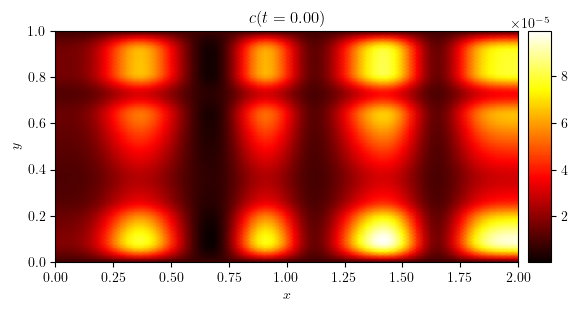

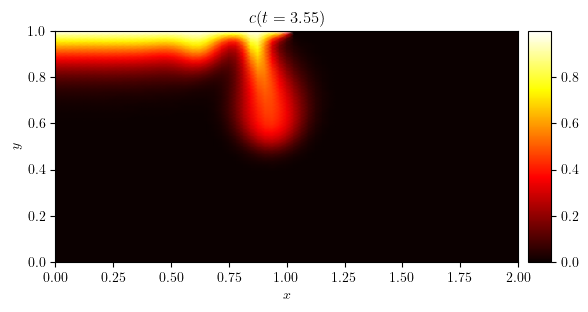

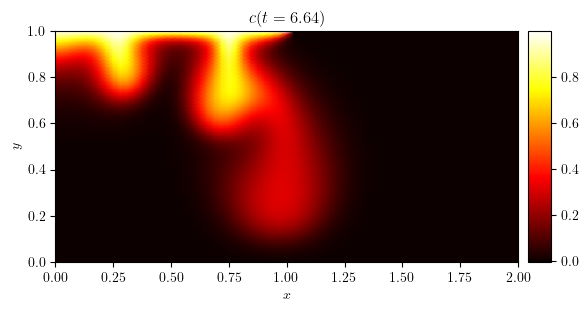

In [3]:
c = simulation['c']

i_mid = int(0.5 * len(c.series))
time_indices = (0, i_mid,  -1)
for i in time_indices:
    fig, ax = plot_colormap(c.series[i], title=f'$c(t={c.time_series[i]:.2f})$')
    write(fig, f'A09_elder_t={c.time_series[i]:.2f}', './figures', close=False, pickle=False)